# Assessment 3:

This notebook builds a prediction model that predicts whether or not a customer who is a target of a campaign is likely to purchase a Term deposit.

As the output is a Yes or No prediction of whether they'll purchase or not, this is a Categorical Prediction problem, with 2 classes - Yes or No.

Ths notebook will illustrate the 16 phases of the AI lifecycle to build this predictor.

# Importing the necessary Python libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The following two commands ignore some warnings which are generally thrown due to version updates.
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Modelling utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics 

# For Modelling 
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Explainability and visualisation libraries
from xgboost import plot_tree
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
# install shap explainability
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 10.3 MB/s 


# Read and explore the data

Read the data into a panda dataframe and view basic stats

In [2]:
data_url = 'https://raw.githubusercontent.com/hdushan/optus_u_ai_ml_assignment/main/bank-term-deposit.csv'
bank_dataset = pd.read_csv(data_url)
bank_dataset.head()
bank_dataset.info()
bank_dataset.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Check for missing values

In [3]:
# trim away whitespace
bank_dataset = bank_dataset.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# replace blanks with NaN
bank_dataset.replace('', np.NaN, inplace=True)
# print number of NaN's for each feature
print(bank_dataset.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


See if data is balanced or biased towards one outcome ('y' being the target variable)

In [4]:
print(bank_dataset['y'].value_counts())
print(bank_dataset['y'].value_counts(normalize=True))

no     36548
yes     4640
Name: y, dtype: int64
no     0.887346
yes    0.112654
Name: y, dtype: float64


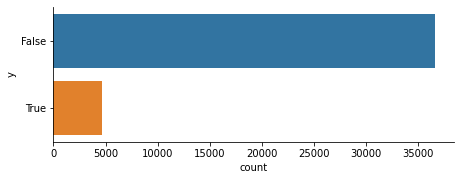

In [44]:
# Visualize the imbalance towards No in a plot
sns.catplot(y="y", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

# Use a heatmap to visualise the data and see pairwise corelation

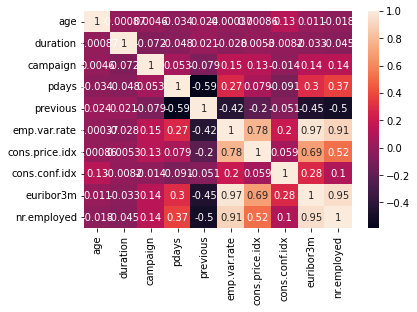

In [6]:
#Use a dataframe function to calculate pairwise correlation 
corr_matrix = bank_dataset.corr()

#and then use seaborn heatmap for viz
sns.heatmap(corr_matrix, annot=True)

# Data Preprocessing

Change the categorical values of the output variable to a boolean:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

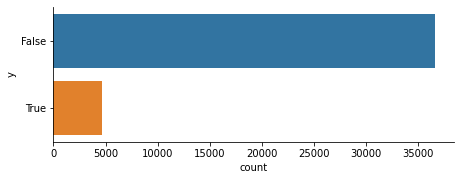

In [43]:
bank_dataset['y'].replace({'yes': True, 'no': False}, inplace=True)

# check to see the output variable and bias hasnt been messed up
bank_dataset.info()
sns.catplot(y="y", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

Use one-hot encoding to encode the features that are strings

In [19]:
# Based on the above output of the info command, the string features are:
# job
# marital
# education
# default
# housing
# loan
# contact
# month (ordinal)
# day_of_week (ordinal)
# poutcome

# print unique values of each of the above string features
print("job: ", bank_dataset.job.unique())
print("marital: ", bank_dataset.marital.unique())
print("education: ", bank_dataset.education.unique())
print("default: ", bank_dataset.default.unique())
print("housing: ", bank_dataset.housing.unique())
print("loan: ", bank_dataset.loan.unique())
print("contact: ", bank_dataset.contact.unique())
print("month: ", bank_dataset.month.unique())
print("day_of_week: ", bank_dataset.day_of_week.unique())
print("poutcome: ", bank_dataset.poutcome.unique())

job:  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital:  ['married' 'single' 'divorced' 'unknown']
education:  ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default:  ['no' 'unknown' 'yes']
housing:  ['no' 'yes' 'unknown']
loan:  ['no' 'yes' 'unknown']
contact:  ['telephone' 'cellular']
month:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week:  ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome:  ['nonexistent' 'failure' 'success']


# Explore each feature and see how many 'unknowns' there are in proportion to other values

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

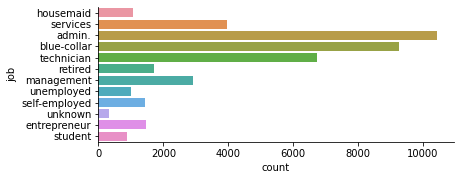

In [42]:
bank_dataset['job'].value_counts()
sns.catplot(y="job", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

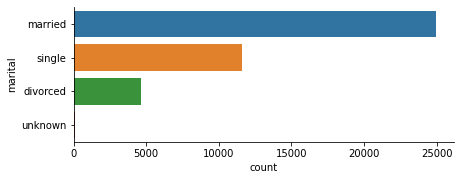

In [41]:
bank_dataset['marital'].value_counts()
sns.catplot(y="marital", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

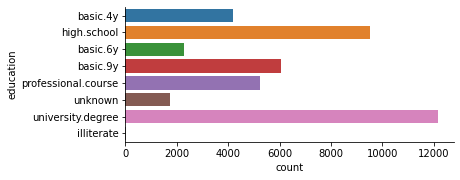

In [40]:
bank_dataset['education'].value_counts()
sns.catplot(y="education", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

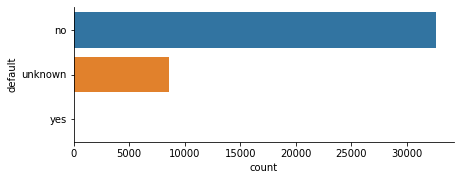

In [39]:
bank_dataset['default'].value_counts()
sns.catplot(y="default", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

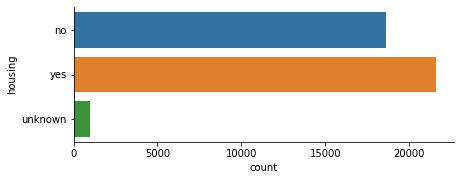

In [38]:
bank_dataset['housing'].value_counts()
sns.catplot(y="housing", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

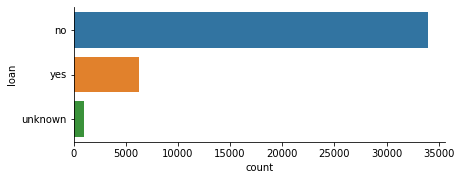

In [37]:
bank_dataset['loan'].value_counts()
sns.catplot(y="loan", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

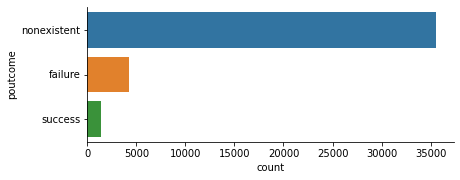

In [36]:
bank_dataset['poutcome'].value_counts()
sns.catplot(y="poutcome", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

# Use one hot encoding to encode all string features

In [45]:
# feature: job

# Prepend column name prior to encoding
bank_dataset['job'] = 'job_' + bank_dataset['job'].astype(str)
# one hot encoding
one_hot_job = pd.get_dummies(bank_dataset['job'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_job)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,56,job_housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,1,0,0,0,0,0,0,0,0
1,57,job_services,married,high.school,unknown,no,no,telephone,may,mon,...,0,0,0,0,0,1,0,0,0,0
2,37,job_services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,0,0,0,1,0,0,0,0
3,40,job_admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0
4,56,job_services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,0,0,0,1,0,0,0,0


In [46]:
# feature: marital

# Prepend column name prior to encoding
bank_dataset['marital'] = 'marital_' + bank_dataset['marital'].astype(str)
# one hot encoding
one_hot_marital = pd.get_dummies(bank_dataset['marital'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_marital)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown
0,56,job_housemaid,marital_married,basic.4y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,1,0,0
1,57,job_services,marital_married,high.school,unknown,no,no,telephone,may,mon,...,0,1,0,0,0,0,0,1,0,0
2,37,job_services,marital_married,high.school,no,yes,no,telephone,may,mon,...,0,1,0,0,0,0,0,1,0,0
3,40,job_admin.,marital_married,basic.6y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,1,0,0
4,56,job_services,marital_married,high.school,no,no,yes,telephone,may,mon,...,0,1,0,0,0,0,0,1,0,0


In [47]:
# feature: education

# Prepend column name prior to encoding
bank_dataset['education'] = 'education_' + bank_dataset['education'].astype(str)
# one hot encoding
one_hot_education = pd.get_dummies(bank_dataset['education'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_education)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,56,job_housemaid,marital_married,education_basic.4y,no,no,no,telephone,may,mon,...,0,0,1,0,0,0,0,0,0,0
1,57,job_services,marital_married,education_high.school,unknown,no,no,telephone,may,mon,...,0,0,0,0,0,1,0,0,0,0
2,37,job_services,marital_married,education_high.school,no,yes,no,telephone,may,mon,...,0,0,0,0,0,1,0,0,0,0
3,40,job_admin.,marital_married,education_basic.6y,no,no,no,telephone,may,mon,...,0,0,0,1,0,0,0,0,0,0
4,56,job_services,marital_married,education_high.school,no,no,yes,telephone,may,mon,...,0,0,0,0,0,1,0,0,0,0


In [48]:
# feature: default

# Prepend column name prior to encoding
bank_dataset['default'] = 'default_' + bank_dataset['default'].astype(str)
# one hot encoding
one_hot_default = pd.get_dummies(bank_dataset['default'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_default)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes
0,56,job_housemaid,marital_married,education_basic.4y,default_no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,1,0,0
1,57,job_services,marital_married,education_high.school,default_unknown,no,no,telephone,may,mon,...,0,0,1,0,0,0,0,0,1,0
2,37,job_services,marital_married,education_high.school,default_no,yes,no,telephone,may,mon,...,0,0,1,0,0,0,0,1,0,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,no,no,telephone,may,mon,...,1,0,0,0,0,0,0,1,0,0
4,56,job_services,marital_married,education_high.school,default_no,no,yes,telephone,may,mon,...,0,0,1,0,0,0,0,1,0,0


In [49]:
# feature: housing

# Prepend column name prior to encoding
bank_dataset['housing'] = 'housing_' + bank_dataset['housing'].astype(str)
# one hot encoding
one_hot_housing = pd.get_dummies(bank_dataset['housing'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_housing)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,no,telephone,may,mon,...,0,0,0,0,1,0,0,1,0,0
1,57,job_services,marital_married,education_high.school,default_unknown,housing_no,no,telephone,may,mon,...,0,0,0,0,0,1,0,1,0,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,no,telephone,may,mon,...,0,0,0,0,1,0,0,0,0,1
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,no,telephone,may,mon,...,0,0,0,0,1,0,0,1,0,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,yes,telephone,may,mon,...,0,0,0,0,1,0,0,1,0,0


In [50]:
# feature: loan

# Prepend column name prior to encoding
bank_dataset['loan'] = 'loan_' + bank_dataset['loan'].astype(str)
# one hot encoding
one_hot_loan = pd.get_dummies(bank_dataset['loan'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_loan)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,telephone,may,mon,...,0,1,0,0,1,0,0,1,0,0
1,57,job_services,marital_married,education_high.school,default_unknown,housing_no,loan_no,telephone,may,mon,...,0,0,1,0,1,0,0,1,0,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,telephone,may,mon,...,0,1,0,0,0,0,1,1,0,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,telephone,may,mon,...,0,1,0,0,1,0,0,1,0,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,telephone,may,mon,...,0,1,0,0,1,0,0,0,0,1


In [51]:
# feature: poutcome

# Prepend column name prior to encoding
bank_dataset['poutcome'] = 'poutcome_' + bank_dataset['poutcome'].astype(str)
# one hot encoding
one_hot_poutcome = pd.get_dummies(bank_dataset['poutcome'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_poutcome)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,telephone,may,mon,...,0,1,0,0,1,0,0,0,1,0
1,57,job_services,marital_married,education_high.school,default_unknown,housing_no,loan_no,telephone,may,mon,...,0,1,0,0,1,0,0,0,1,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,telephone,may,mon,...,0,0,0,1,1,0,0,0,1,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,telephone,may,mon,...,0,1,0,0,1,0,0,0,1,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,telephone,may,mon,...,0,1,0,0,0,0,1,0,1,0


In [52]:
#To avoid multicollinearity, we must drop one of the new columns created during one hot encoding
bank_dataset = bank_dataset.drop(columns=['job', 'marital', 'education', 
                                          'default', 'housing', 'loan', 
                                          'contact', 'month', 'day_of_week', 
                                          'poutcome'])

bank_dataset.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,1,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,1,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,1,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,1,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0


# Building the model

In [53]:
# use the numpy split function to split the data into training set, test set and validation set
train, test, validate = np.split(bank_dataset.sample(frac=1), [int(.6*len(bank_dataset)), int(.8*len(bank_dataset))])
print (train.shape, test.shape, validate.shape)

(24712, 47) (8238, 47) (8238, 47)


In [54]:
#Prepare the input (X) and output (Y) columns for each set 
X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

X_validate = validate.drop(columns=['y'])
y_validate = validate[['y']]

X_train.head()
y_train.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
9094,41,190,1,999,0,1.4,94.465,-41.8,4.967,5228.1,...,0,0,1,0,0,1,0,0,1,0
2966,60,150,1,999,0,1.1,93.994,-36.4,4.859,5191.0,...,0,1,0,0,1,0,0,0,1,0
1347,38,166,1,999,0,1.1,93.994,-36.4,4.855,5191.0,...,0,1,0,0,1,0,0,0,1,0
9624,57,302,1,999,0,1.4,94.465,-41.8,4.961,5228.1,...,0,1,0,0,0,0,1,0,1,0
24587,38,555,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,1,1,0,0,0,1,0


,y
9094,False
2966,False
1347,False
9624,False
24587,False


In [55]:
#Logistic regression 
hrLogReg = LogisticRegression()
#fit the model on the training data
hrLogReg.fit(X_train, y_train)

LogisticRegression()

In [56]:
#Decision tree 
hrDecisionTree = tree.DecisionTreeClassifier()
hrDecisionTree.fit(X_train,y_train)

DecisionTreeClassifier()

In [57]:
# K-nearest neighbour 
hrKNN = neighbors.KNeighborsClassifier()
hrKNN.fit(X_train,y_train)

KNeighborsClassifier()

In [58]:
# XGBoost 
hrXGB = xgb.XGBClassifier()
hrXGB.fit(X_train,y_train)

XGBClassifier()

In [59]:
# Neural network - Multi-layer Perceptron
hrMLP = MLPClassifier()
hrMLP.fit(X_train,y_train)

MLPClassifier()

# Model evaluation

In [60]:
classifiers = [ hrMLP, hrXGB, hrKNN, hrDecisionTree, hrLogReg]
evalTable = PrettyTable(['Name', 'Accuracy', 'F1-score', 'ROC AUC score', 'AP score'])
for i in classifiers:
  # Predict the class
  y_predict = i.predict(X_test)
  # Predict probabilities and retrieve just the probabilities for the positive class
  y_prob = i.predict_proba(X_test)[:, 1]
  evalTable.add_row( [ type(i).__name__, (round(i.score(X_test, y_test),3)), 
                      (round(metrics.f1_score(y_test, y_predict),3)), 
                      (round(metrics.roc_auc_score(y_test, y_prob),3)), 
                      (round(metrics.average_precision_score(y_test, y_prob),3)),] )

print(evalTable)

+------------------------+----------+----------+---------------+----------+
|          Name          | Accuracy | F1-score | ROC AUC score | AP score |
+------------------------+----------+----------+---------------+----------+
|     MLPClassifier      |  0.787   |  0.502   |     0.919     |   0.54   |
|     XGBClassifier      |  0.912   |  0.572   |      0.94     |  0.631   |
|  KNeighborsClassifier  |  0.898   |  0.525   |     0.869     |  0.485   |
| DecisionTreeClassifier |  0.885   |  0.521   |     0.734     |  0.325   |
|   LogisticRegression   |  0.905   |  0.496   |     0.916     |  0.564   |
+------------------------+----------+----------+---------------+----------+


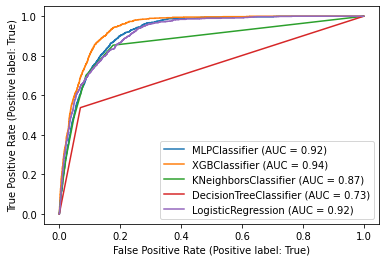

In [61]:
# Plot the ROC curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=all_axes)

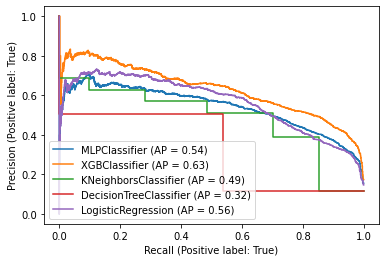

In [62]:
# Plot the precision-recall curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_precision_recall_curve(i, X_test, y_test, ax=all_axes)

# Model explainability

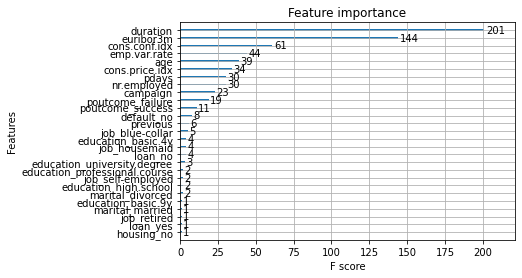

In [63]:
# Plot the feature importance for the XGB classifier
xgb.plot_importance(hrXGB)

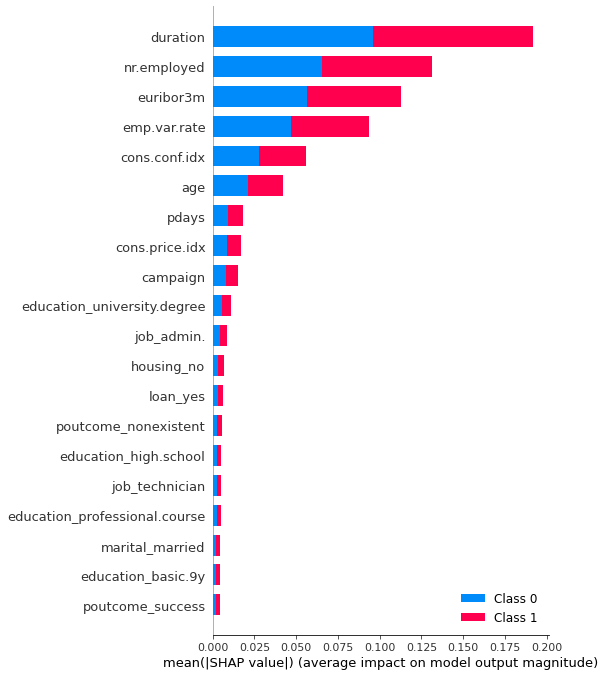

In [64]:
import shap
shapExplainer = shap.TreeExplainer(hrDecisionTree) 
shapExplainer_values = shapExplainer.shap_values(X_train)
shap.summary_plot(shapExplainer_values, X_train)

Sumary plot showing direction of influence of each feature on the target variable

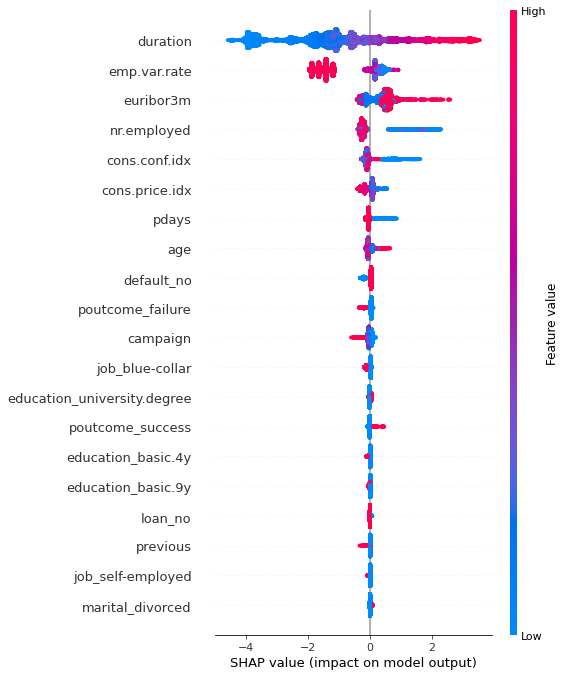

In [66]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(hrXGB)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)